## Startup

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

import os
import pickle

import yfinance as yf

yf.pdr_override()

In [2]:
np.random.seed(42)

In [3]:
from scripts.params import get_params

params = get_params()

# all downloadable tickers
tickerlist = params["tickerlist"]

# only stock tickers - excludes index
stockslist = params["stockslist"]

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]

for folder_path in params["directories"]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

## Data Retrieval

In [5]:
ohlclist = ["Open", "High", "Low", "Close"]

In [6]:
objectlist = []

for item in tickerlist:
    objectlist.append(yf.Ticker(item))

In [7]:
def download_or_load_data(start, end, tablename, datatype, dataroute):
    name = f"dataset_{datatype}_{tablename}.pickle"
    filename = os.path.join(dataroute, name)
    if not os.path.exists(filename):
        data = {}
        for ticker in objectlist:
            # descargo data en un diccionario[ticker]
            data[ticker.ticker] = ticker.history(start=start, end=end)
            # guardo en un pickle
        with open(filename, "wb") as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    else:
        with open(filename, "rb") as handle:
            data = pickle.load(handle)
    return data

In [8]:
train_data = download_or_load_data(
    start=params["start_train"],
    end=params["end_train"],
    tablename=params["tablename"],
    datatype="train",
    dataroute=dataroute,
)

test_data = download_or_load_data(
    start=params["start_test"],
    end=(pd.to_datetime(params["end_test"]) + pd.Timedelta(days=7)).strftime(
        "%Y-%m-%d"
    ),
    tablename=params["tablename"],
    datatype="test",
    dataroute=dataroute,
)

datasets = [train_data, test_data]

## Data quality deletion

In [9]:
dq_index = pd.to_datetime(params["data_quality_dates"])

In [10]:
for data in datasets:
    for ticker in tickerlist:
        data[ticker].index = data[ticker].index.date
        data[ticker] = data[ticker].drop(dq_index, errors="ignore")

## Implicit USD calculation

In [11]:
def _reindex_refill_dfs(df1, df2):
    """
    The function returns two dataframes with an index as the union of the two.
    The dataframes are then forward filled.
    """
    index3 = df1.index.union(df2.index)
    # reindex both con index3
    df3 = df1.reindex(index3)
    df4 = df2.reindex(index3)
    # fillna con previous value
    df3.ffill(inplace=True)
    df4.ffill(inplace=True)
    return df3, df4

In [12]:
def calculate_usd(usd_df, ars_df, conversion_factor):
    """
    The function returns a dataframe with an index the size of the union between the two.
    Missing values in dates (stemming from, for example, holidays in one country) are
    forward filled to create the last
    """
    usd_df_r, ars_df_r = _reindex_refill_dfs(usd_df, ars_df)
    implicit_usd = ars_df_r.divide(usd_df_r) * conversion_factor
    return implicit_usd

In [13]:
usd_col_set = set()

for data in datasets:
    for foreign, local, factor in params["stocksdict"].values():
        usd_col_set.add(f"USD_{foreign}")
        data[f"USD_{foreign}"] = calculate_usd(
            data[foreign][ohlclist], data[local][ohlclist], factor
        )
        data[f"USD_{foreign}"]["Average"] = data[f"USD_{foreign}"].mean(axis=1)

usd_col_set

{'USD_ABEV', 'USD_ERJ', 'USD_PBR', 'USD_VALE'}

In [14]:
for data in datasets:
    data["USD"] = pd.DataFrame(columns=ohlclist)

    for i in ohlclist:
        df = pd.concat([data[col][i] for col in usd_col_set], axis=1)
        data["USD"][i] = df.mean(axis=1)

    data["USD"]["Average"] = data["USD"].mean(axis=1)

In [15]:
for data in datasets:
    for key in data.keys():
        data[key].ffill(inplace=True)
        # revisar esto

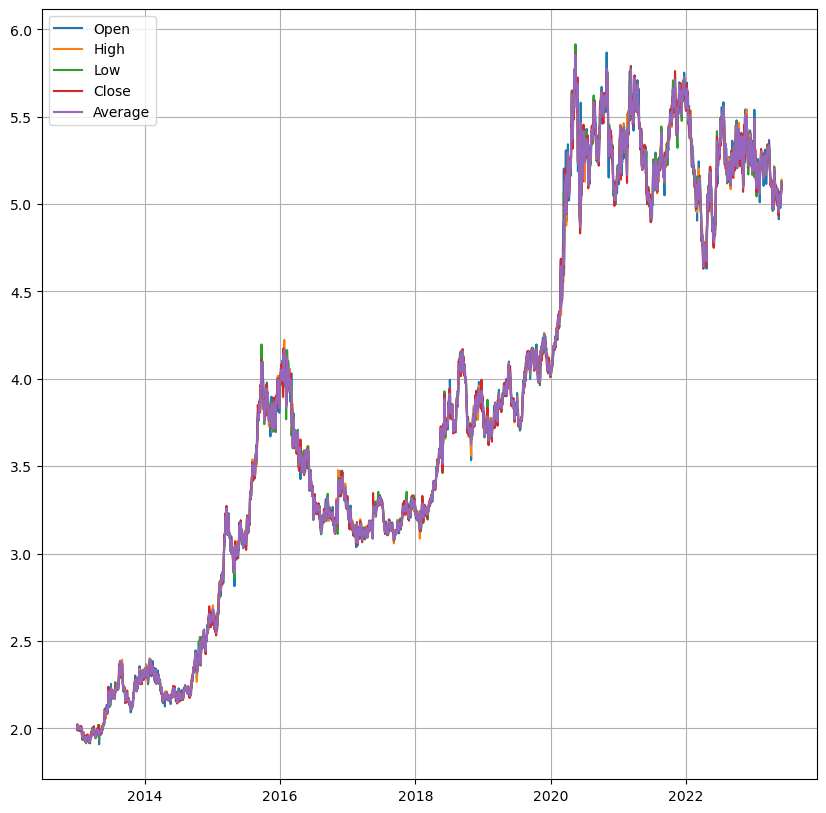

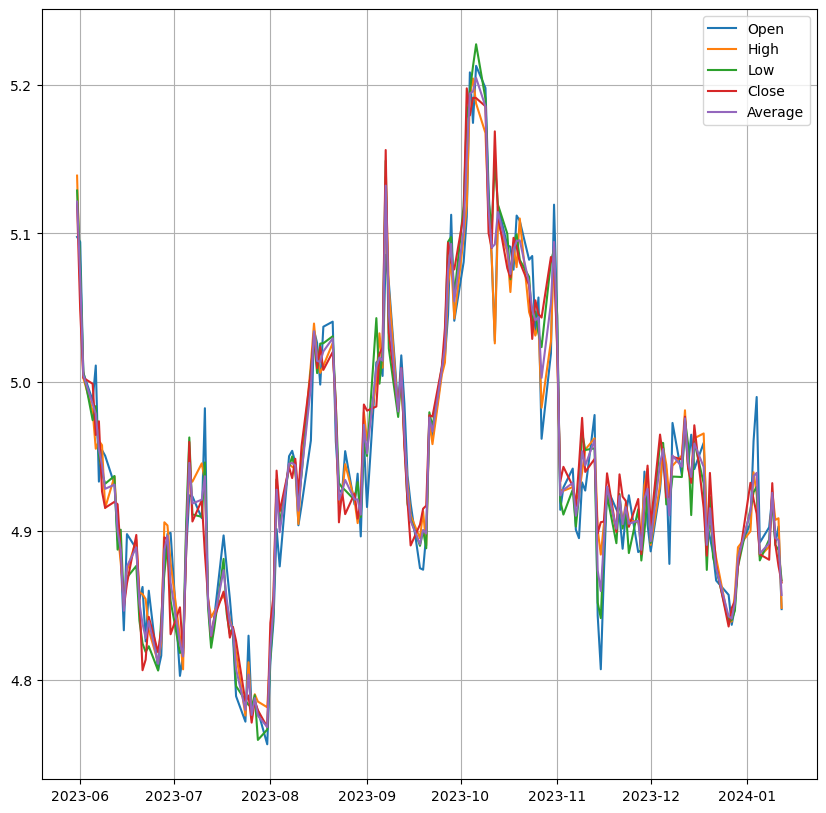

In [16]:
for data in datasets:
    data["USD"][[*ohlclist, "Average"]].plot(figsize=(10, 10), logy=False, grid=True)

## USD Denominated Index

In [17]:
for data in datasets:
    usdindex_name=f"""{params["index"].replace('^', '')}_USD"""
    
    data[usdindex_name] = pd.DataFrame(columns=ohlclist)

    for col in ohlclist:
        data[usdindex_name][col] = (
            data[params["index"]][col] / data["USD"]["Average"]
        )

    data[usdindex_name].ffill(inplace=True)

## Intraday Volatility

Vamos a usar para medir intraday volatility el estimador de Garman and Klass (1980):

$$V_{ohlc}=0.5*[log(H)-log(L)]^2+(2*log(2)-1)*[log(C)-log(O)]^2$$ 
Donde H es el precio mas alto del día, L el bajo, C el cierre y O su apertura

Garman, M. B. and M. J. Klass (1980). On the estimation of security price volatilities from historical data. Journal of Business 53, 67–78.

In [18]:
def gk_vol(o, h, l, c):
    "Returns Garman Klass (1980) intraday volatility estimator"
    return (
        0.5 * (np.log(h) - np.log(l)) ** 2
        + (2 * np.log(2) - 1) * (np.log(c) - np.log(o)) ** 2
    )

## Returns Calculation

In [19]:
for data in datasets:
    for ticker in data.keys():
        view = data[ticker]
        view["rets"] = view["Close"] / view["Close"].shift() - 1
        view["log_rets"] = np.log(view["Close"] / view["Close"].shift())
        view["norm_range"] = (view["High"] - view["Low"]) / view["Open"]
        view["gk_vol"] = gk_vol(
            o=view["Open"], h=view["High"], l=view["Low"], c=view["Close"]
        )
        # delete first observation to eliminate nans
        data[ticker] = data[ticker][1:].copy()

## Process into single dataframe, matching dates and forward filling
Véase https://github.com/alfsn/regime-switching-hmm/issues/9

In [20]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_datasets = [df_train, df_test]

for df, data in zip(df_datasets, datasets):
    for key, value in data.items():
        for column in ["rets", "log_rets", "gk_vol"]:
            df[key + "_" + column] = value[column]

In [21]:
for df in df_datasets:
    df.loc[df.isna().any(axis=1), df.isna().any(axis=0)]
    df.fillna(0, inplace=True)

## Excluimos los dólares implícitos

In [22]:
datasets[0].keys()

dict_keys(['^BVSP', 'VALE3.SA', 'VALE', 'PETR3.SA', 'PBR', 'EMBR3.SA', 'ERJ', 'ABEV3.SA', 'ABEV', 'USD_VALE', 'USD_PBR', 'USD_ERJ', 'USD_ABEV', 'USD', 'BVSP_USD'])

In [23]:
delete_usdlist = True

for data in datasets:
    usdlist = []

    for key in data.keys():

        if "USD" in key:

            usdlist.append(key)

    usdlist.remove("USD")

    usdlist.remove(usdindex_name)


    print(usdlist)

    if delete_usdlist:
        for col in usdlist:
            del data[col]

['USD_VALE', 'USD_PBR', 'USD_ERJ', 'USD_ABEV']
['USD_VALE', 'USD_PBR', 'USD_ERJ', 'USD_ABEV']


## Save dataset

In [24]:
for data, name in zip(datasets, ["train", "test"]):
    processedname = "processed_" + name + "_" + params["tablename"] + ".pickle"
    with open(os.path.join(dataroute, processedname), "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
particular_USDs = [
    column
    for column in df.columns
    if ((column.startswith("USD")) and (params["index"].replace('^', '') not in column))
]
particular_USDs.remove("USD_rets")
particular_USDs.remove("USD_log_rets")
particular_USDs.remove("USD_gk_vol")
particular_USDs

['USD_VALE_rets',
 'USD_VALE_log_rets',
 'USD_VALE_gk_vol',
 'USD_PBR_rets',
 'USD_PBR_log_rets',
 'USD_PBR_gk_vol',
 'USD_ERJ_rets',
 'USD_ERJ_log_rets',
 'USD_ERJ_gk_vol',
 'USD_ABEV_rets',
 'USD_ABEV_log_rets',
 'USD_ABEV_gk_vol']

In [26]:
df_clean_datasets = []

if delete_usdlist:

    for df in df_datasets:
        df_clean = df.drop(columns=particular_USDs)

        assert not (df_clean.isna()).any().any(), "Existen n/a"
        df_clean_datasets.append(df_clean)

In [27]:
for df_clean, name in zip(df_clean_datasets, ["train", "test"]):
    finaldfname = "finaldf_" + name + "_" + params["tablename"] + ".pickle"
    with open(os.path.join(dataroute, finaldfname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)